In [1]:
library(readr)
library(dplyr)
library(tibble)  # for rownames_to_column()

# Read count matrices
counts1 <- read_csv("/home/jpereira/Results/kraken_snake/MG1/Data/merge_bracken/bracken_merged_G_new_est_reads.csv")
counts2 <- read_csv("/home/jpereira/Results/kraken_snake/MG2/Data/merge_bracken/bracken_merged_G_new_est_reads.csv")

# Convert to data frames
counts_mat1 <- as.data.frame(counts1)
counts_mat2 <- as.data.frame(counts2)

# Set species as rownames
rownames(counts_mat1) <- counts_mat1[[1]]
rownames(counts_mat2) <- counts_mat2[[1]]
counts_mat1 <- counts_mat1[, -1]
counts_mat2 <- counts_mat2[, -1]

# Convert rownames back to columns for joining
counts_mat1 <- counts_mat1 %>% rownames_to_column(var = "Species")
counts_mat2 <- counts_mat2 %>% rownames_to_column(var = "Species")

# Perform full join
merged_counts <- full_join(counts_mat1, counts_mat2, by = "Species")

# Replace NA with 0
merged_counts[is.na(merged_counts)] <- 0

# Set rownames back to species
rownames(merged_counts) <- merged_counts$Species
merged_counts <- merged_counts[, -1]  # remove Species column

# Now `merged_counts` is ready for DESeq2



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Rows: 575 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): name
dbl (20): PR26NR001MG, PR26NR007MG, PR26NR026MG, PR26NR042MG, PR26NR044MG, P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 575 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): name
dbl (10): NS001_MG, NS002_MG, NS003_MG, NS004_MG, NS005_MG, NS006_MG, NS007_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”


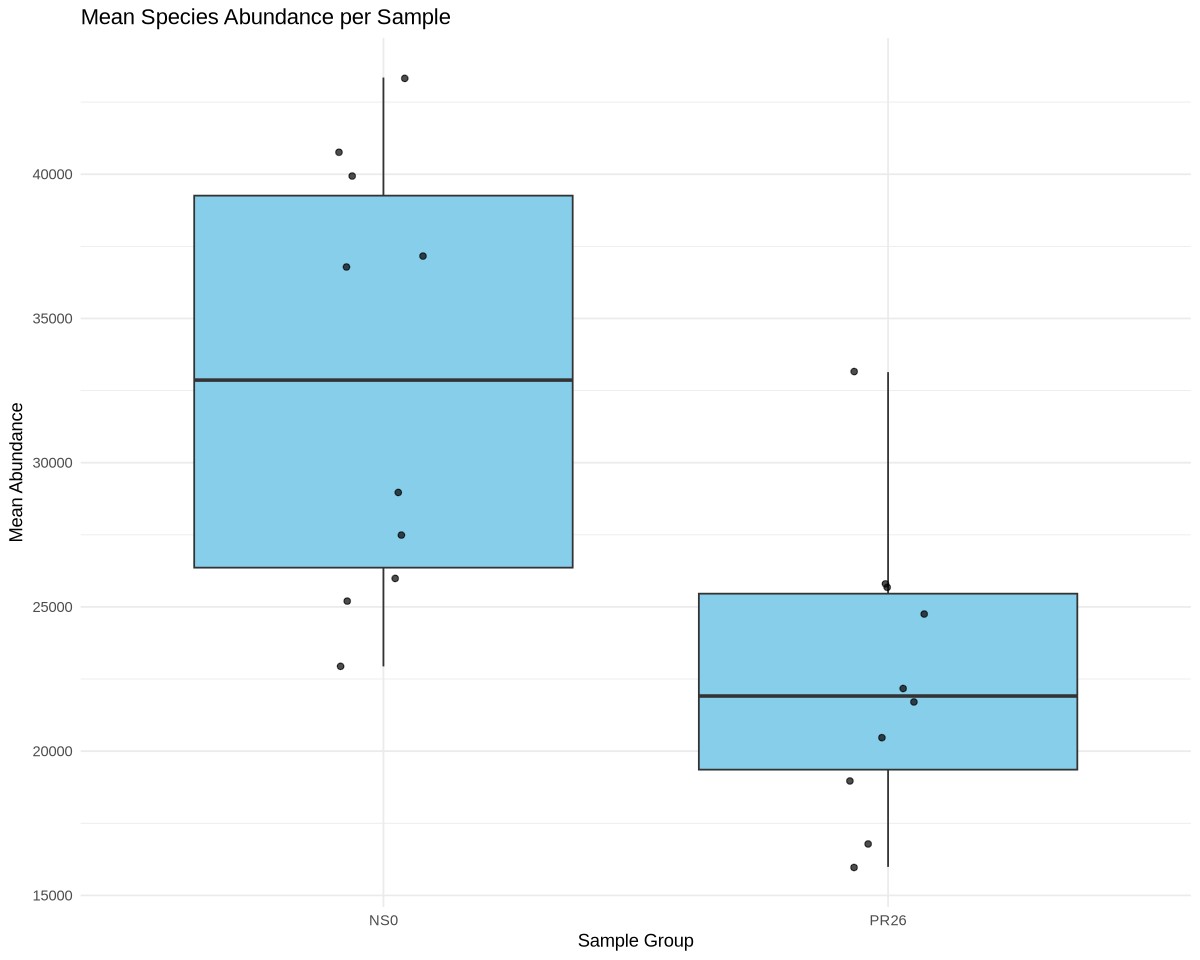

In [2]:
library(dplyr)
library(ggplot2)
library(tibble)  # for rownames_to_column

options(repr.plot.width = 10, repr.plot.height = 8)

# Transpose so samples become rows and species become columns
sample_means <- merged_counts %>%
  t() %>%
  as.data.frame() %>%
  rownames_to_column(var = "Sample") %>%
  mutate(mean_abundance = rowMeans(select(., -Sample)))

# Label samples as either 'PR26' or 'NS0'
sample_means <- sample_means %>%
  mutate(Group = case_when(
    grepl("^PR26", Sample) ~ "PR26",
    grepl("^NS0", Sample)  ~ "NS0",
    TRUE ~ "Other"
  ))

ggplot(sample_means %>% filter(Group != "Other"), aes(x = Group, y = mean_abundance)) +
  geom_boxplot(fill = "skyblue") +
  labs(title = "Mean Species Abundance per Sample",
       x = "Sample Group", y = "Mean Abundance") +
  theme_minimal() + geom_jitter(width = 0.1, alpha = 0.7)


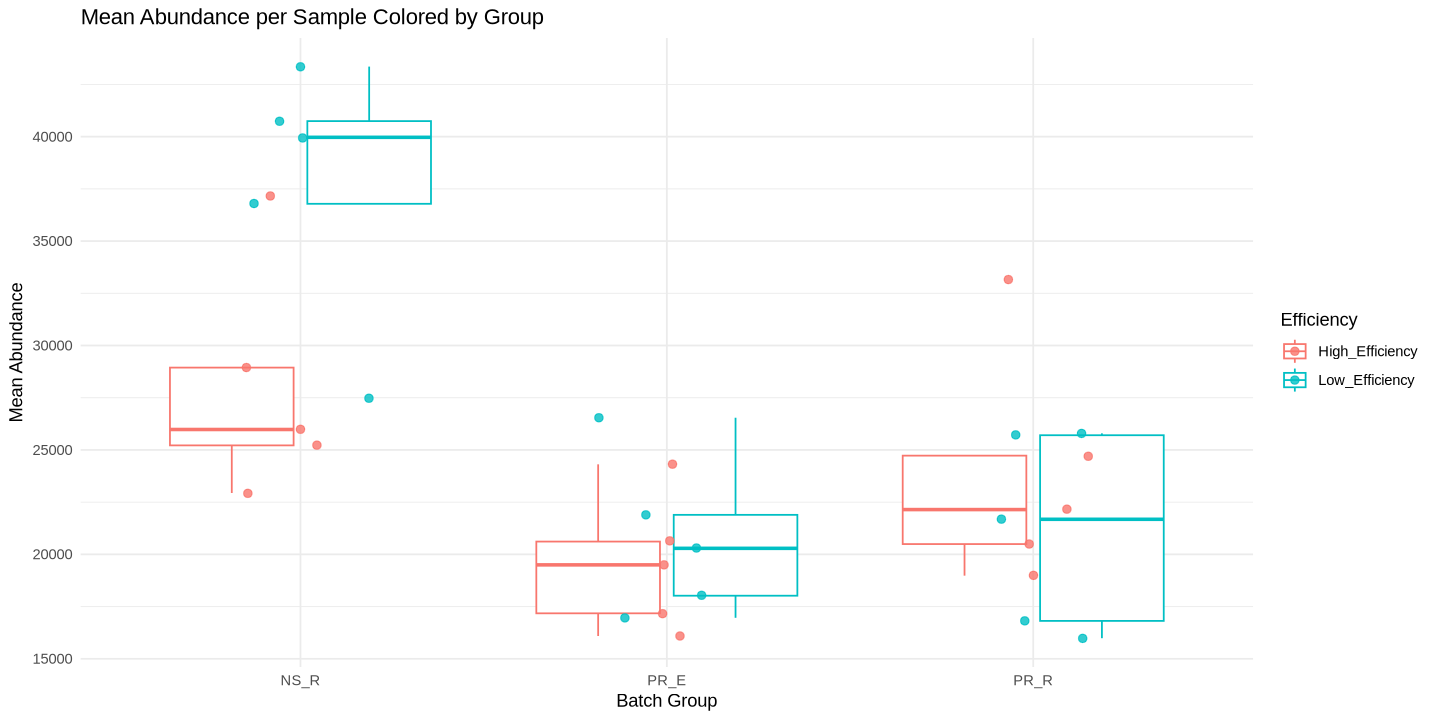

In [3]:
library(ggplot2)

# Read metadata
metadata <- read.delim("../metadata/metadata.MG1_MG2.csv")

options(repr.plot.width = 12, repr.plot.height = 6)

# Make sure LABID and Sample match exactly (same type, no whitespace)
sample_means_annotated <- sample_means %>%
  left_join(metadata, by = c("Sample" = "LABID"))

ggplot(sample_means_annotated, aes(x = Group.y, y = mean_abundance, color = Efficiency)) +
  geom_boxplot(outlier.shape = NA) +  # Don't double-plot outliers
  geom_jitter(width = 0.2, size = 2, alpha = 0.8) +
  labs(title = "Mean Abundance per Sample Colored by Group",
       x = "Batch Group", y = "Mean Abundance") +
  theme_minimal()


In [4]:
library(dplyr)
library(DESeq2)

run_deseq2_by_categories <- function(metadata,
                                     count_matrix,
                                     sample_id_col       = "LABID",
                                     group_col,
                                     categories,
                                     condition_col        = "Efficiency",
                                     contrast_levels      = c("High_Efficiency", "Low_Efficiency"),
                                     batch_col            = NULL,
                                     p_adjust_threshold   = 0.10,
                                     log2FC_threshold     = 1.0,
                                     min_total_count      = 10,
                                     out_file_dir         = ".",
                                     out_file_prefix      = "deseq2_results_") {
  # ---------------------------------------------------------------------------------
  # Args:
  #   metadata:         data.frame or tibble containing at least:
  #                       - a column named sample_id_col (e.g. "LABID") with sample IDs
  #                       - a column named group_col (from which we pick categories)
  #                       - a column named condition_col (for DESeq2 design)
  #                       - if batch_col is not NULL, a column named batch_col
  #
  #   count_matrix:     data.frame or matrix of raw counts:
  #                       - rows = features (e.g. species)
  #                       - cols = samples; column names must match metadata[[sample_id_col]]
  #
  #   sample_id_col:    (string) name of the column in metadata that holds sample IDs
  #   group_col:        (string) name of the column in metadata to filter by categories
  #   categories:       (character vector) values in metadata[[group_col]] to keep
  #
  #   condition_col:     (string) name of the metadata column to use in the DESeq2 design
  #   contrast_levels:   (length-2 character vector) the two levels of condition_col to compare
  #                      e.g. c("High_Efficiency", "Low_Efficiency")
  #
  #   batch_col:         (string or NULL) name of the metadata column to use as a batch factor.
  #                      If NULL, batch is not included. If provided, design = ~ batch_col + condition_col.
  #
  #   p_adjust_threshold:(numeric) FDR cutoff to define “significant” features (default = 0.05)
  #
  #   log2FC_threshold:  (numeric) minimum absolute log2 fold‐change to consider a feature “significant”
  #
  #   min_total_count:   (numeric) minimum total count across all samples for a feature to be kept
  #                      (default = 10)
  #
  #   out_file_dir:      (string) directory in which to write the CSV result
  #
  #   out_file_prefix:   (string) prefix for the output CSV filename; categories will be appended
  #
  # Returns:
  #   A list with components:
  #     $dds       → the DESeqDataSet object (after running DESeq)
  #     $res       → the full DESeq2 result table (DataFrame)
  #     $res_sig   → subset of $res with padj < p_adjust_threshold and |log2FC| ≥ log2FC_threshold
  #
  # Side effect:
  #   Writes both the full result table (`res`) and the significant subset (`res_sig`)
  #   as CSV files in `out_file_dir`.
  # ---------------------------------------------------------------------------------
  
  # 1. Check that sample_id_col, group_col, and condition_col exist in metadata
  required_cols <- c(sample_id_col, group_col, condition_col)
  if (!all(required_cols %in% colnames(metadata))) {
    missing <- setdiff(required_cols, colnames(metadata))
    stop("Missing column(s) in metadata: ", paste(missing, collapse = ", "))
  }
  
  # 2. Subset metadata by categories in group_col
  meta_sub <- metadata %>%
    filter(.data[[group_col]] %in% categories)
  
  if (nrow(meta_sub) < 2) {
    stop("After filtering by categories = {", paste(categories, collapse = ", "), 
         "} in '", group_col, "', fewer than 2 samples remain.")
  }
  
  # 3. Check that condition_col has ≥ 2 levels in this subset
  cond_levels <- unique(meta_sub[[condition_col]])
  if (length(cond_levels) < 2) {
    stop("The condition column '", condition_col,
         "' has fewer than 2 unique levels in the filtered metadata.")
  }
  
  # 4. If batch_col is provided, check existence and ≥ 2 levels
  if (!is.null(batch_col)) {
    if (!batch_col %in% colnames(meta_sub)) {
      stop("`batch_col = '", batch_col, "'` not found in metadata columns.")
    }
    batch_levels <- unique(meta_sub[[batch_col]])
    if (length(batch_levels) < 2) {
      stop("The batch column '", batch_col,
           "' has fewer than 2 unique levels in the filtered metadata.")
    }
    design_formula <- as.formula(paste("~", batch_col, "+", condition_col))
  } else {
    design_formula <- as.formula(paste("~", condition_col))
  }
  
  # 5. Extract the vector of sample IDs
  sample_ids <- meta_sub[[sample_id_col]]
  
  # 6. Subset the count matrix to those columns (samples)
  if (!all(sample_ids %in% colnames(count_matrix))) {
    missing_ids <- setdiff(sample_ids, colnames(count_matrix))
    stop("The following sample IDs are not in count_matrix: ", 
         paste(missing_ids, collapse = ", "))
  }
  counts_sub <- count_matrix[, sample_ids, drop = FALSE]
  
  # 7. Remove features (rows) with zero total count
  counts_sub <- counts_sub[rowSums(counts_sub) > 0, , drop = FALSE]
  
  # 8. Set sample IDs as rownames in metadata
  rownames(meta_sub) <- meta_sub[[sample_id_col]]
  
  # 9. Create DESeqDataSet
  dds <- DESeqDataSetFromMatrix(
    countData = round(as.matrix(counts_sub)),
    colData   = meta_sub,
    design    = design_formula
  )
  
  # 10. Filter out features with total count < min_total_count
  keep_feat <- rowSums(counts(dds)) >= min_total_count
  dds       <- dds[keep_feat, ]
  if (nrow(dds) < 2) {
    stop("After filtering for min_total_count, fewer than 2 features remain.")
  }
  
  # 11. Run DESeq
  dds <- DESeq(dds)
  
  # 12. Extract results for the specified contrast (condition_col: level1 vs level2)
  res <- results(dds, contrast = c(condition_col,
                                   contrast_levels[1],
                                   contrast_levels[2]))
  
  # 13. Replace NA adjusted p-values with 1
  res$padj[is.na(res$padj)] <- 1
  
  # 14. Subset to significant hits (FDR & log2FC thresholds)
  res_sig <- res %>%
    as.data.frame() %>%
    rownames_to_column(var = "feature") %>%
    filter(padj < p_adjust_threshold & abs(log2FoldChange) >= log2FC_threshold) %>%
    column_to_rownames(var = "feature")
  
  # 15. Build output filenames using joined categories
  categories_string <- paste(categories, collapse = "|")
  batch_part <- if (!is.null(batch_col)) paste0("_batch-", batch_col) else ""
  
  res_filename     <- paste0(
    out_file_prefix, "full_results.groups-", categories_string,
    "_cond-", condition_col, batch_part, ".csv"
  )
  sig_res_filename <- paste0(
    out_file_prefix, "significant_results.groups-", categories_string,
    "_cond-", condition_col, batch_part, ".csv"
  )
  
  res_file_path     <- file.path(out_file_dir, res_filename)
  sig_res_file_path <- file.path(out_file_dir, sig_res_filename)
  
  # 16. Write full result table and significant subset to CSV
  message("Saving full results to: ", res_file_path)
  write.csv(as.data.frame(res), file = res_file_path, row.names = TRUE)
  
  message("Saving significant results (padj < ", p_adjust_threshold,
          ", |log2FC| ≥ ", log2FC_threshold, ") to: ", sig_res_file_path)
  write.csv(as.data.frame(res_sig), file = sig_res_file_path, row.names = TRUE)
  
  # 17. Return list
  return(list(
    dds     = dds,
    res     = res,
    res_sig = as.data.frame(res_sig),
    file_name_prefixes = list(
      prefix          = out_file_prefix,
      groups          = categories_string,
      condition       = condition_col,
      batch_component = batch_part
    )
  ))
}

Warning message:
“package ‘DESeq2’ was built under R version 4.4.3”
Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.4.2”
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.4.2”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.mi

In [5]:
library(dplyr)
library(ggplot2)
library(ggrepel)

# ---------------------------------------------------------------------------------
# Function: make_volcano_plot
#
# This function creates a volcano plot from a DESeq2 result object (or data frame).
#
# Args:
#   res_obj            : DESeq2 results object, or a data frame with at least:
#                        - log2FoldChange
#                        - padj
#                        - row names corresponding to feature names (e.g., Species)
#
#   pval_cutoff        : Numeric. FDR cutoff used to flag “significant” points (default = 0.05).
#   lfc_cutoff         : Numeric. Absolute log2 fold-change cutoff to flag “significant” (default = 1.0).
#   label_pval_cutoff  : Numeric. FDR cutoff used to select “top hits” to label (default = 0.10).
#   label_lfc_cutoff   : Numeric. Absolute log2 fold-change cutoff used to select “top hits” (default = 1.0).
#
#   out_file           : String. Full path (including “.pdf”) for saving the volcano plot.
#   width              : Numeric. Width of the PDF in inches (default = 24).
#   height             : Numeric. Height of the PDF in inches (default = 12).
#
# Returns:
#   Invisibly returns a list with two data frames:
#     $res_df       → the full data frame used for plotting (with columns Species, padj, log2FoldChange, Significant).
#     $top_hits_df  → the subset of $res_df that will be labelled on the plot.
#
# Side‐effect:
#   Creates and writes a PDF at out_file.
# ---------------------------------------------------------------------------------
make_volcano_plot <- function(res_obj,
                              pval_cutoff       = 0.05,
                              lfc_cutoff        = 1.0,
                              label_pval_cutoff = 0.10,
                              label_lfc_cutoff  = 1.0,
                              out_file,
                              width  = 24,
                              height = 12) {
  # 1. Ensure res_obj is a data frame with rownames
  if (inherits(res_obj, "DESeqResults") || inherits(res_obj, "DESeqDataSet")) {
    res_df <- as.data.frame(res_obj)
  } else if (is.data.frame(res_obj)) {
    res_df <- res_obj
  } else {
    stop("res_obj must be either a DESeqResults object or a data frame.")
  }
  
  # 2. Add a “Species” (feature) column from rownames
  res_df <- res_df %>%
    rownames_to_column(var = "Species")
  
  # 3. Replace NA padj with 1 (so that -log10(padj) will be zero)
  res_df <- res_df %>%
    mutate(padj = ifelse(is.na(padj), 1, padj))
  
  # 4. Create a “Significant” flag based on pval_cutoff and lfc_cutoff
  res_df <- res_df %>%
    mutate(Significant = ifelse(padj < pval_cutoff & abs(log2FoldChange) > lfc_cutoff,
                                "Yes", "No"))
  
  # 5. Identify “top hits” to label: padj < label_pval_cutoff AND |log2FC| > label_lfc_cutoff
  top_hits_df <- res_df %>%
    filter(padj < label_pval_cutoff,
           abs(log2FoldChange) > label_lfc_cutoff) %>%
    arrange(padj)
  
  # 6. Open PDF device
  pdf(out_file, width = width, height = height)
  
  # 7. Draw volcano plot
  p <- ggplot(res_df, aes(x = log2FoldChange, y = -log10(padj), color = Significant)) +
    geom_point(alpha = 0.7) +
    scale_color_manual(values = c("No" = "gray", "Yes" = "red")) +
    geom_vline(xintercept = c(-lfc_cutoff, lfc_cutoff), linetype = "dashed") +
    geom_hline(yintercept = -log10(pval_cutoff), linetype = "dashed") +
    geom_text_repel(
      data = top_hits_df,
      aes(label = Species),
      size = 3
    ) +
    labs(
      title = "Volcano Plot of DESeq2 Results",
      x     = "Log2 Fold Change",
      y     = "-Log10 Adjusted P-value"
    ) +
    theme_minimal()
  
  print(p)
  dev.off()
  
  # 8. Return data frames invisibly
  invisible(list(res_df      = res_df,
                 top_hits_df = top_hits_df))
}


In [11]:
library(dplyr)
library(DESeq2)
library(ggplot2)
library(ggrepel)

# (Assume run_deseq2_by_categories() and make_volcano_plot() 
#  are already defined in your environment.)

# 1) Define your sets of categories as a LIST of character vectors
col_groups <- list(
  c("PR_R"),
  c("PR_E"),
  c("NS_R"),
  c("PR_R", "NS_R")
)

# 2) Set up your output directories
out_dir_data    <- "/home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2"
out_dir_visuals <- "/home/jpereira/Results/kraken_snake/MG1_MG2/Visuals/Deseq2"

# 3) Loop over each “group” (which itself is a character vector of categories)
for (group in col_groups) {
  
  # 4) Run DESeq2 on exactly those samples whose metadata$Group ∈ group
  results_list <- run_deseq2_by_categories(
    metadata        = metadata,
    count_matrix    = merged_counts,
    sample_id_col   = "LABID",
    group_col       = "Group",
    categories      = group,
    condition_col   = "Efficiency",
    contrast_levels = c("High_Efficiency", "Low_Efficiency"),
    batch_col       = NULL,
    min_total_count = 50,
    out_file_dir    = out_dir_data,
    out_file_prefix = ""
  )
  
  # 5) Extract the DESeq2 “res” table from the returned list
  res <- results_list$res

  
  # 6) Build the PDF filename for the volcano plot
  out_prefixes <- results_list$file_name_prefixes
  print("OUT PREFIXES")
  print(out_prefixes)
  volcano_file_name <- paste0(
      "annotated-volcano_", "groups-", out_prefixes$groups,
      "_cond-", out_prefixes$condition, out_prefixes$batch_component, ".pdf"
    )
  outfile_visuals <- file.path(out_dir_visuals, volcano_file_name  )
  
  # 7) Make the volcano plot and save it to that PDF
  make_volcano_plot(
    res_obj           = res,
    pval_cutoff       = 0.05,
    lfc_cutoff        = 1.0,
    label_pval_cutoff = 0.10,
    label_lfc_cutoff  = 1.0,
    out_file          = outfile_visuals,
    width             = 24,
    height            = 12
  )
}


converting counts to integer mode



Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

Saving full results to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/full_results.groups-PR_R_cond-Efficiency.csv

Saving significant results (padj < 0.1, |log2FC| ≥ 1) to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/significant_results.groups-PR_R_cond-Efficiency.csv



[1] "OUT PREFIXES"
$prefix
[1] ""

$groups
[1] "PR_R"

$condition
[1] "Efficiency"

$batch_component
[1] ""



converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

Saving full results to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/full_results.groups-PR_E_cond-Efficiency.csv

Saving significant results (padj < 0.1, |log2FC| ≥ 1) to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/significant_results.groups-PR_E_cond-Efficiency.csv



[1] "OUT PREFIXES"
$prefix
[1] ""

$groups
[1] "PR_E"

$condition
[1] "Efficiency"

$batch_component
[1] ""



converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

Saving full results to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/full_results.groups-NS_R_cond-Efficiency.csv

Saving significant results (padj < 0.1, |log2FC| ≥ 1) to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/significant_results.groups-NS_R_cond-Efficiency.csv



[1] "OUT PREFIXES"
$prefix
[1] ""

$groups
[1] "NS_R"

$condition
[1] "Efficiency"

$batch_component
[1] ""



converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 25 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

Saving full results to: /home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2/full_results.groups-PR_R|NS_R_cond-Efficiency.csv

Saving significant results (padj < 0.1, |log2FC| ≥ 1) to: /home/jpereira/Results/kraken_sna

[1] "OUT PREFIXES"
$prefix
[1] ""

$groups
[1] "PR_R|NS_R"

$condition
[1] "Efficiency"

$batch_component
[1] ""



In [7]:
results_list[4]

$file_name_prefixes
$file_name_prefixes$prefix
[1] ""

$file_name_prefixes$groups
[1] "PR_R|NS_R"

$file_name_prefixes$condition
[1] "Efficiency"

$file_name_prefixes$batch_component
[1] ""

In [8]:
library(DESeq2)

# Filter to samples in group PR_R
meta_ss <- metadata %>%
  filter(Group == "PR_R")

# Check sample IDs
head(meta_ss$LABID)

# Keep only PR_R samples in the count matrix
counts_ss <- merged_counts[, meta_ss$LABID]

# Optional: remove species with no counts
counts_ss <- counts_ss[rowSums(counts_ss) > 0, ]


# Set LABID as rownames in metadata
rownames(meta_ss) <- meta_ss$LABID

# Create DESeq2 object using Efficiency as condition
dds <- DESeqDataSetFromMatrix(
  countData = round(as.matrix(counts_ss)),
  colData = meta_ss,
  design = ~ Efficiency
)

# Filter out low abundance features
dds <- dds[rowSums(counts(dds)) > 10, ]

# Run DESeq2
dds <- DESeq(dds)

# Get results: e.g., Efficiency_H vs Efficiency_L
# Replace these with the actual levels of your Efficiency column
res <- results(dds, contrast = c("Efficiency", "High_Efficiency", "Low_Efficiency"))

# View results
summary(res)
res_sig <- res[which(res$padj < 0.05), ]
head(res_sig)

# Save results
write.csv(as.data.frame(res), "deseq2_PR_R_efficiency_results.csv")


[1] "PR26NR067MG" "PR26NR063MG" "PR26NR042MG" "PR26NR026MG" "PR26NR007MG"
[6] "PR26NR001MG"

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing




out of 575 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.17%
LFC < 0 (down)     : 1, 0.17%
outliers [1]       : 31, 5.4%
low counts [2]     : 0, 0%
(mean count < 29)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): Efficiency High_Efficiency vs Low_Efficiency 
Wald test p-value: Efficiency High_Efficiency vs Low_Efficiency 
DataFrame with 1 row and 6 columns
         baseMean log2FoldChange     lfcSE      stat     pvalue      padj
        <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
UBA2804   92906.9        2.26183  0.531372   4.25659 2.0757e-05 0.0112918

In [9]:
library(dplyr)
library(ggplot2)
library(ggrepel)

# 1. Convert DESeq2 results to a data frame and add a “Significant” flag
res_df <- as.data.frame(res) %>%
  mutate(
    Species       = rownames(res),
    padj          = ifelse(is.na(padj), 1, padj),
    Significant   = ifelse(padj < 0.05 & abs(log2FoldChange) > 1, "Yes", "No")
  )

# 2. Grab the top hits
top_hits <- res_df %>%
  filter(padj < 0.10, abs(log2FoldChange) > 1) %>%
  arrange(padj)

# 3. Save the plot as PDF
pdf("/home/jpereira/Results/kraken_snake/MG1_MG2/Visuals/Deseq2/annotated_volcano.PR_R.Efficiency.pdf", 
    width = 24, height = 12)

# 4. Draw the volcano plot
print(
  ggplot(res_df, aes(x = log2FoldChange, y = -log10(padj), color = Significant)) +
    geom_point(alpha = 0.7) +
    scale_color_manual(values = c("No" = "gray", "Yes" = "red")) +
    geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_text_repel(
      data = top_hits,
      aes(label = Species),
      size = 3
    ) +
    labs(
      title = "Volcano Plot of DESeq2 Results",
      x     = "Log2 Fold Change",
      y     = "-Log10 Adjusted P-value"
    ) +
    theme_minimal()
)

dev.off()


pdf 
  2

In [10]:

# Read metadata
metadata <- read.delim("../metadata/metadata.MG1_MG2.csv")
rownames(metadata) <- metadata$`sample-id`  # set sample names as rownames

# Ensure sample names match
counts_mat <- counts_mat[, rownames(metadata)]  # re-order columns to match metadata

# Build DESeq2 dataset
dds <- DESeqDataSetFromMatrix(
    countData = round(counts_mat),
    colData = metadata,
    design = ~ Diet  # change this to your factor of interest
)

# Filter low-count features
dds <- dds[rowSums(counts(dds)) > 10, ]

# Run DESeq2
dds <- DESeq(dds)

# Get results
res <- results(dds, contrast = c("Diet", "Grain", "Grass"))  # Grain vs Grass
res <- lfcShrink(dds, coef=2, res=res)  # Optional: shrink fold changes

# View significant results
res_sig <- res[which(res$padj < 0.05), ]
head(res_sig)

# Save results
write.csv(as.data.frame(res), file="deseq2_results.csv")


ERROR: Error: object 'counts_mat' not found


In [ ]:
results_list <- run_deseq2_by_categories(
  metadata        = metadata,
  count_matrix    = merged_counts,
  sample_id_col   = "LABID",
  group_col       = "Group",
  categories      = c("PR_R"),
  condition_col   = "Efficiency",
  contrast_levels = c("High_Efficiency", "Low_Efficiency"),
  batch_col       = NULL,
  min_total_count    = 10,
  out_file_dir       = "/home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2",
  out_file_prefix    = ""
)

results_list <- run_deseq2_by_categories(
  metadata        = metadata,
  count_matrix    = merged_counts,
  sample_id_col   = "LABID",
  group_col       = "Group",
  categories      = c("PR_E"),
  condition_col   = "Efficiency",
  contrast_levels = c("High_Efficiency", "Low_Efficiency"),
  batch_col       = NULL,
  min_total_count    = 10,
  out_file_dir       = "/home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2",
  out_file_prefix    = ""
)

results_list <- run_deseq2_by_categories(
  metadata        = metadata,
  count_matrix    = merged_counts,
  sample_id_col   = "LABID",
  group_col       = "Group",
  categories      = c("NS_R"),
  condition_col   = "Efficiency",
  contrast_levels = c("High_Efficiency", "Low_Efficiency"),
  batch_col       = NULL,
  min_total_count    = 10,
  out_file_dir       = "/home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2",
  out_file_prefix    = ""
)


results_list <- run_deseq2_by_categories(
  metadata        = metadata,
  count_matrix    = merged_counts,
  sample_id_col   = "LABID",
  group_col       = "Group",
  categories      = c("PR_R","NS_R"),
  condition_col   = "Efficiency",
  contrast_levels = c("High_Efficiency", "Low_Efficiency"),
  batch_col       = NULL,
  min_total_count    = 10,
  out_file_dir       = "/home/jpereira/Results/kraken_snake/MG1_MG2/Data/Deseq2",
  out_file_prefix    = ""
)

